## Image Data Analysis

### Read example image with cv2

In [1]:
from cv2 import imdecode, IMREAD_UNCHANGED
import json
import requests
import numpy as np

all_data = json.load(open('./merged.json'))

def get_image_data(img_url):
    get_image = requests.get(img_url, stream=True)
    raw_image_data = get_image.raw
    image_array = np.asarray(bytearray(raw_image_data.read()), dtype="uint8")
    image_data = imdecode(image_array, IMREAD_UNCHANGED)
    return image_data


In [2]:
height, width, num_channels = get_image_data(all_data['001']['sprites'][0]).shape
(height, width, num_channels)

(120, 120, 3)

In [18]:
from urllib.parse import urlparse
from tqdm import tqdm

def apply_transformation(data):
    try:
        res = json.load(open('./post_transformation.json'))
    except Exception:
        res = {}
    for ndex in tqdm(list(data.keys())[:150]):
        if res.get(ndex) is None:
            res[ndex] = data[ndex].copy()
            res[ndex]['sprites'] = {}
        sprites = data[ndex]['sprites']
        for sprite_url in sprites[:-200]:
            if sprite_url not in res[ndex]['sprites']:
                # print(f'fetching {sprite_url}')
                try:
                    image_data = get_image_data(sprite_url)
                    ext = sprite_url.split('.')[-1].lower().strip()
                    if ((image_data is None) or (image_data.shape is None)):
                        print(f'found no image data or shape is none for {ndex}:{sprite_url}')
                        height = width = num_channels = 'inf'
                    else:
                        height, width, *rest = image_data.shape
                        num_channels = rest[0] if rest else 0
                    res[ndex]['sprites'][sprite_url] = {
                        # 'url': sprite_url,
                        'height': height,
                        'width': width,
                        'num_channels': num_channels,
                        'ext': ext,
                        'domain': urlparse(sprite_url).netloc
                    }
                except Exception as e:
                    print(f'error capturing {ndex}:{sprite_url}')
                    print(e)
            else:
                pass
                # print(f'skipping {sprite_url}')
    return res
    

In [19]:
updated_image_data = apply_transformation(all_data)
json.dump(updated_image_data, open('post_transformation.json', 'w'), indent=4)

 47%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 71/150 [00:00<00:00, 687.02it/s]

error capturing 071:https://archives.bulbagarden.net/media/upload/thumb/4/43/Team_Rocket_party_Original_series.png/120px-Team_Rocket_party_Original_series.png
OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:816: error: (-215:Assertion failed) !buf.empty() in function 'cv::imdecode_'



 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 134/150 [09:28<04:08, 15.53s/it]

found no image data or shape is none for 135:https://archives.bulbagarden.net/media/upload/thumb/9/9f/Aeroblast_PMD_GTI_2.png/120px-Aeroblast_PMD_GTI_2.png


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 143/150 [11:37<01:47, 15.43s/it]

found no image data or shape is none for 144:https://archives.bulbagarden.net/media/upload/thumb/d/dd/023257_P_FURIZA.jpg/86px-023257_P_FURIZA.jpg


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 144/150 [11:53<01:33, 15.50s/it]

found no image data or shape is none for 145:https://archives.bulbagarden.net/media/upload/thumb/3/3f/GalarianZapdosVVMAXClimax237.jpg/86px-GalarianZapdosVVMAXClimax237.jpg


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 145/150 [12:05<01:11, 14.28s/it]

found no image data or shape is none for 146:https://archives.bulbagarden.net/media/upload/thumb/e/ef/GalarianMoltresVVMAXClimax242.jpg/86px-GalarianMoltresVVMAXClimax242.jpg


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [13:17<00:00,  5.32s/it]


In [39]:
from collections import Counter

import pandas as pd
import numpy as np

domain_counter = Counter()
ext_counter = Counter()
heights = []
widths = []
w_h = []

for ndex in list(updated_image_data.keys())[:4]:
    pokemon_data = updated_image_data[ndex]
    for url in pokemon_data['sprites'].keys():
        sprite = pokemon_data['sprites'][url]
        # heights.append(sprite['height'])
        # widths.append(sprite['width'])
        w_h.append([sprite['height'], sprite['width']])
        domain_counter[sprite['domain']] += 1
        ext_counter[sprite['ext']] += 1

size_df = pd.DataFrame(data=w_h, columns=['height', 'width'])
size_df = size_df.replace(to_replace='inf', value=np.nan).dropna()

print(domain_counter)
print(ext_counter)
print(size_df)

Counter({'archives.bulbagarden.net': 800, 'raw.githubusercontent.com': 12})
Counter({'png': 689, 'jpg': 122, 'svg': 1})
     height  width
0     120.0  120.0
1      56.0   56.0
2      56.0   56.0
3      96.0   96.0
4      40.0   40.0
..      ...    ...
807   108.0  120.0
808   119.0   66.0
809    68.0  120.0
810    56.0   56.0
811   120.0  120.0

[810 rows x 2 columns]


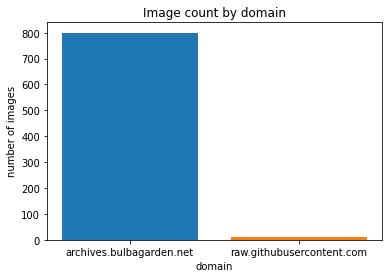

In [21]:
import matplotlib.pyplot as plt

plt.title('Image count by domain')
plt.xlabel('domain')
plt.ylabel('number of images')
for domain, count in domain_counter.items():
    plt.bar(domain, count)


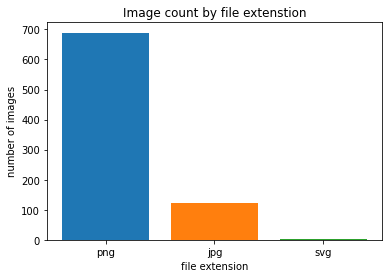

In [22]:
plt.title('Image count by file extenstion')
plt.xlabel('file extension')
plt.ylabel('number of images')
for ext, count in ext_counter.items():
    plt.bar(ext, count)

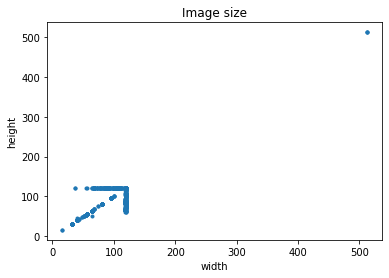

In [42]:
plt.title('Image size')
plt.xlabel('width')
plt.ylabel('height')
plt.scatter(size_df['height'], size_df['width'], marker='.')